In [1]:
### Datasets of this study can be download from  http://spatial.libd.org/spatialLIBD/
#https://github.com/QihuangZhang/CeLEry/blob/main/code_paper/1_LIBD/preprocess.py


import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
from skimage import io, color

from scipy.sparse import issparse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt


#Read original data and save it to h5ad
from scanpy import read_10x_h5
import CeLEry as cel
import json
import time


In [2]:
### ------------------------------------------------------------------------------------------------------- ###
###        Process the genelist
### ------------------------------------------------------------------------------------------------------- ###
def get_LIBD_top_DEgenes (studyID):
    """
    Preprocess the spatial transcriptomic raw data and obtain the optimal DE genes
    Parameters
        -----------
        studyID : string. the study ID of the LIBD datasets
    Returns
    -----------
        gene_topDE_list: the list of gene set that contains the highest DE genes between layers
    """
    adata = read_10x_h5("{studyID}/{studyID}_raw_feature_bc_matrix.h5".format(studyID = studyID))
    spatial = pd.read_csv("{studyID}_tissue_positions_list.txt".format(studyID = studyID),sep=",", header = None, na_filter = False, index_col = 0) 
    adata.obs["x1"] = spatial[1]
    adata.obs["x2"] = spatial[2]
    adata.obs["x3"] = spatial[3]
    # Select captured samples
    adata = adata[adata.obs["x1"] == 1]
    adata.var_names = [i.upper() for i in list(adata.var_names)]
    adata.var["genename"] = adata.var.index.astype("str")
    #
    del adata.obs["x1"]
    #
    adata.obs["Layer"] = 0
    LayerName =["L1","L2","L3","L4","L5","L6","WM"] #
    for i in range(7):
        Layer = pd.read_csv("{studyID}/{studyID}_{Lname}_barcodes.txt".format(studyID = studyID, Lname = LayerName[i]), sep=",", header = None, na_filter = False, index_col = 0)
        adata.obs.loc[Layer.index, "Layer"] = int(i+1)
        adata.obs.loc[Layer.index, "Layer_character"] = LayerName[i]
    data = adata[adata.obs["Layer"]!=0]    # Newly added on May 25 #Remove the spots without any layer label
    #
    #  Preprocessing
    adata.var_names_make_unique()
    cel.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
    cel.prefilter_specialgenes(adata)
    #Normalize and take log for UMI-------
    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    #
    sc.tl.rank_genes_groups(adata, 'Layer_character', method = 'wilcoxon', key_added = "wilcoxon")
    # sc.pl.rank_genes_groups(adata, n_genes = 200, sharey = False, key="wilcoxon", save = '{studyID}.pdf'.format(studyID = studyID))
    gene_topDE_list = []
    for layer_i in ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']:
        gene_rank = sc.get.rank_genes_groups_df (adata,  group = layer_i, key = 'wilcoxon')
        top_gene_list = list(gene_rank["names"].iloc[0:200])
        gene_topDE_list.append( top_gene_list  )
    return gene_topDE_list


In [3]:
genelist73 = get_LIBD_top_DEgenes (151673)
genelist74 = get_LIBD_top_DEgenes (151674)
genelist75 = get_LIBD_top_DEgenes (151675)

In [4]:
genelist76 = get_LIBD_top_DEgenes (151676)
genelist07 = get_LIBD_top_DEgenes (151507)
genelist08 = get_LIBD_top_DEgenes (151508)
genelist09 = get_LIBD_top_DEgenes (151509)
genelist10 = get_LIBD_top_DEgenes (151510)

In [7]:
# Get the gene list from the pre-screening
genelistlist = genelist73 + genelist74 + genelist75 + genelist76 + genelist07 + genelist08 + genelist09 + genelist10
genelist = sum(genelistlist, [])  # merge the list of lists
genelistuni = list( dict.fromkeys(genelist) )   # remove duplicates

In [3]:
def Preprocess_SpTrans (studyID):
    """
    Preprocess the spatial transcriptomic raw data and obtain the optimal DE genes
    Parameters:
        studyID (string): the study ID of the LIBD datasets
    Returns:
        gene_topDE_list (list): the list of gene set that contains the highest DE genes between layers
    """
    # Read in the spatial transcriptomic data from a 10x Genomics-formatted HDF5 file
    adata = sc.read_10x_h5(f"{studyID}/{studyID}_raw_feature_bc_matrix.h5")
    
    # Read in the spatial coordinates of the tissue samples from a CSV file
    spatial = pd.read_csv(f"{studyID}/{studyID}_tissue_positions_list.txt", sep=",", header=None, na_filter=False, index_col=0) 
    
    # Add the spatial coordinates to the data object
    adata.obs["x1"] = spatial[1]
    adata.obs["x2"] = spatial[2]
    adata.obs["x3"] = spatial[3]
    
    # Select only the samples that were captured
    adata = adata[adata.obs["x1"] == 1]
    
    # Ensure that all gene names are uppercase
    adata.var_names = [i.upper() for i in list(adata.var_names)]
    
    # Add the gene names as a column in the `var` attribute of the `adata` object
    adata.var["genename"] = adata.var.index.astype("str")
    
    # Remove the "x1" column from the `obs` attribute of the `adata` object
    del adata.obs["x1"]
    
    # Add a "Layer" column to the `obs` attribute of the `adata` object and initialize it to 0
    adata.obs["Layer"] = 0
    
    # Define a list of layer names
    LayerName =["L1", "L2", "L3", "L4", "L5", "L6", "WM"]
    
    # Loop through each layer and add the corresponding layer number to the `Layer` column of the `adata` object
    # Also add the layer name as a separate column for convenience
    for i in range(7):
        Layer = pd.read_csv(f"{studyID}/{studyID}_{LayerName[i]}_barcodes.txt", sep=",", header=None, na_filter=False, index_col=0)
        adata.obs.loc[Layer.index, "Layer"] = int(i+1)
        adata.obs.loc[Layer.index, "Layer_character"] = LayerName[i]
    
    # Remove the spots without any layer label
    adata = adata[adata.obs["Layer"] != 0]
    
    # Make the gene names unique
    adata.var_names_make_unique()
    
    # Filter out genes that are expressed in fewer than 3 cells
    cel.prefilter_genes(adata, min_cells=3)
    
    # Filter out special genes (e.g. mitochondrial genes)
    cel.prefilter_specialgenes(adata)
    
    # Normalize the data by cell and take the log of the UMI counts
    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    #
    sc.tl.rank_genes_groups(adata, 'Layer_character', method = 'wilcoxon', key_added = "wilcoxon")
    sc.pl.rank_genes_groups(adata, n_genes = 50, sharey = False, key="wilcoxon", save = '{studyID}.pdf'.format(studyID = studyID))
    #
    #  Filter the Genes that are selected by SpaGCN
    genename = adata.var['genename']
    genelistindex = [genename[genename == i].index[0] for i in genelistuni if  len(genename[genename == i])>0]  # only keep the genes that exists in SpT data
    # Filter the genelist and output the results
    bdata = adata[:,genelistindex]
    cdata = sc.AnnData(X = bdata.X.toarray(), obs = bdata.obs, var = bdata.var, uns =bdata.uns, obsm = bdata.obsm)
    cdata.write_h5ad("data_{studyID}.h5ad".format(studyID = studyID))
    return genelistindex

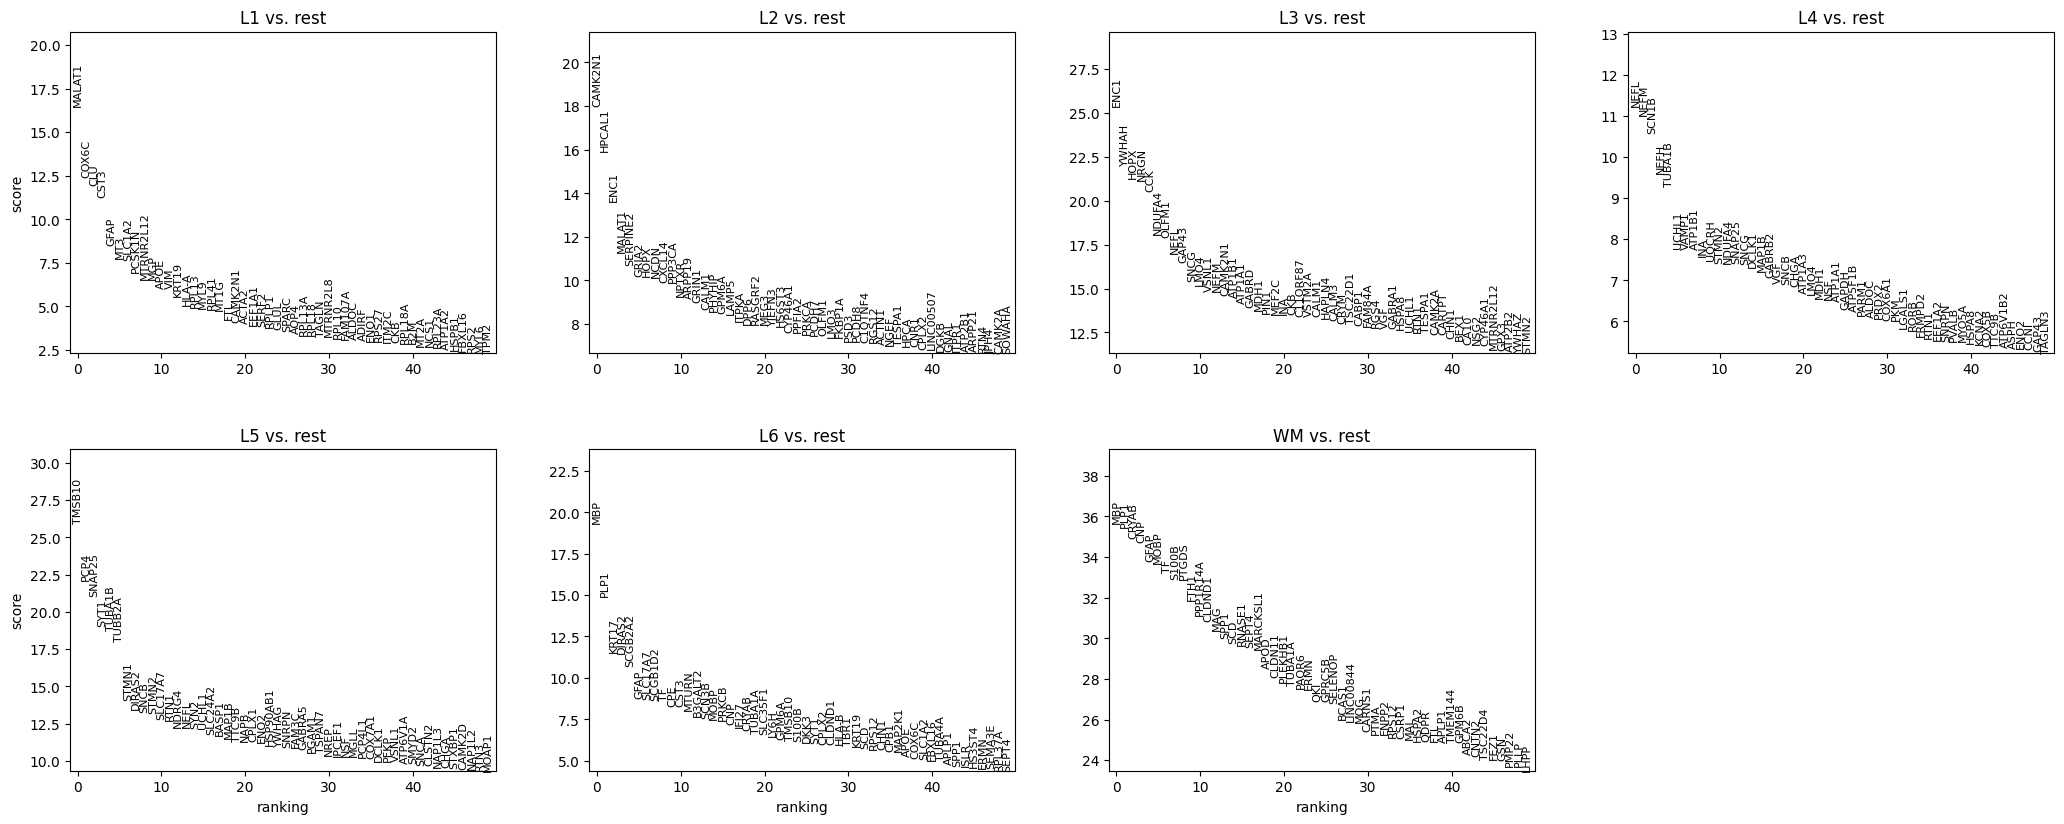

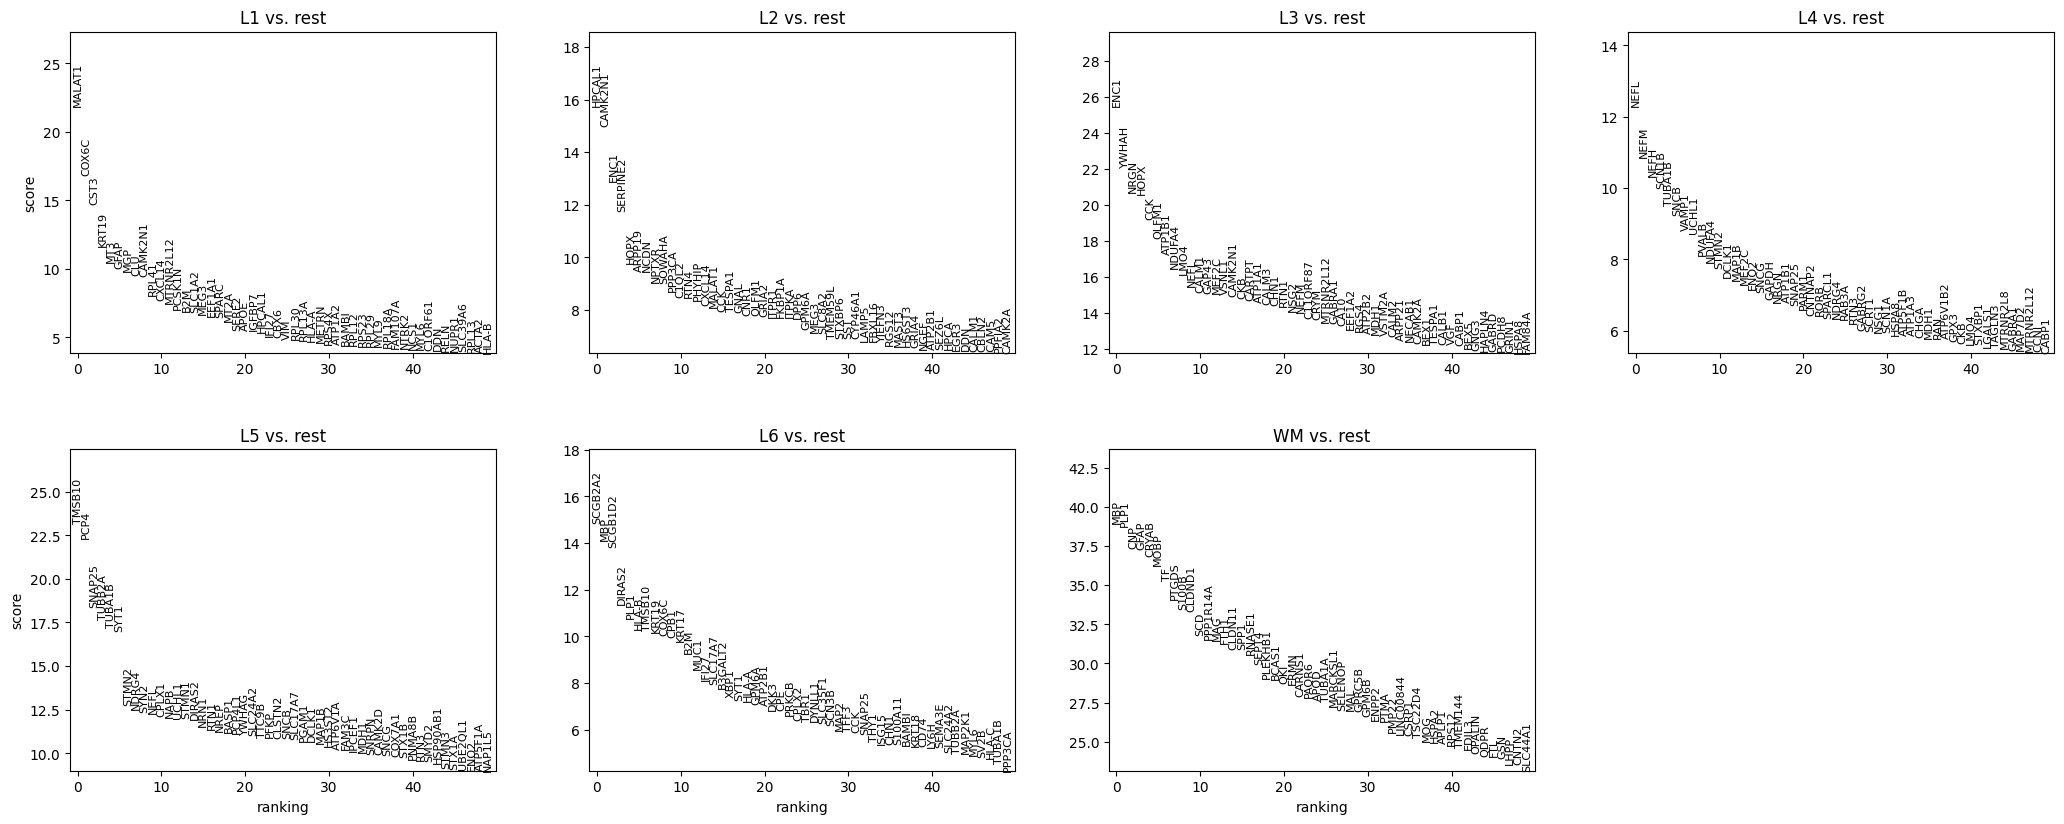

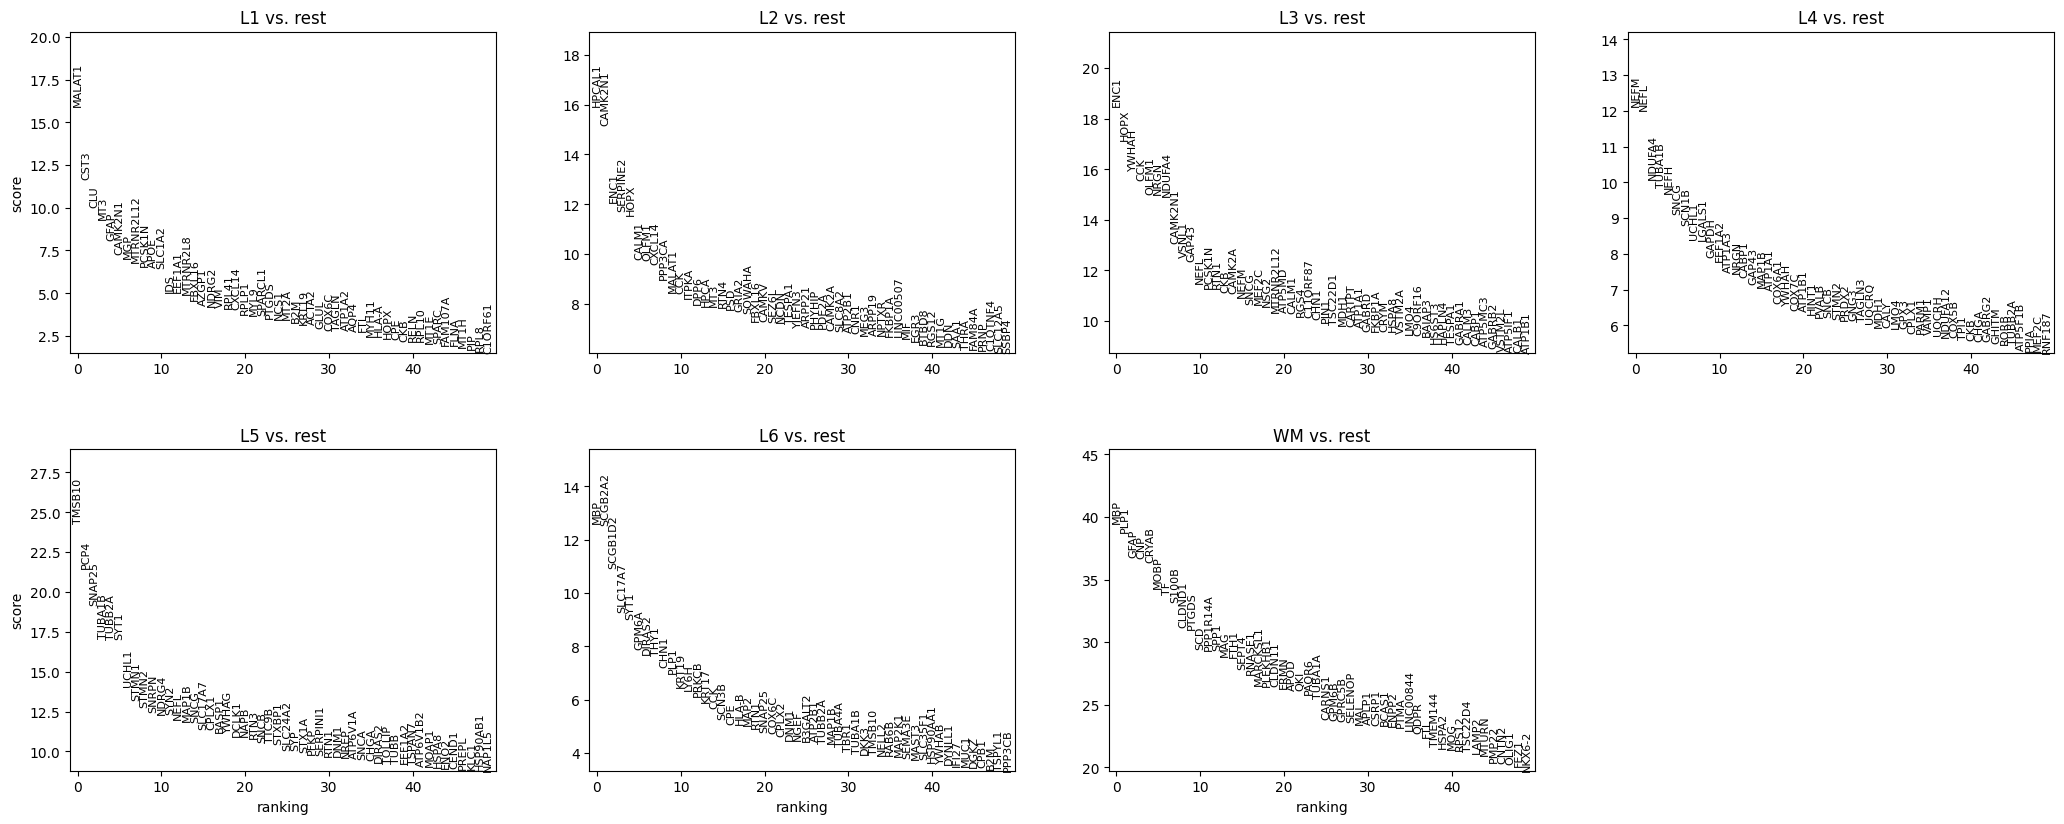

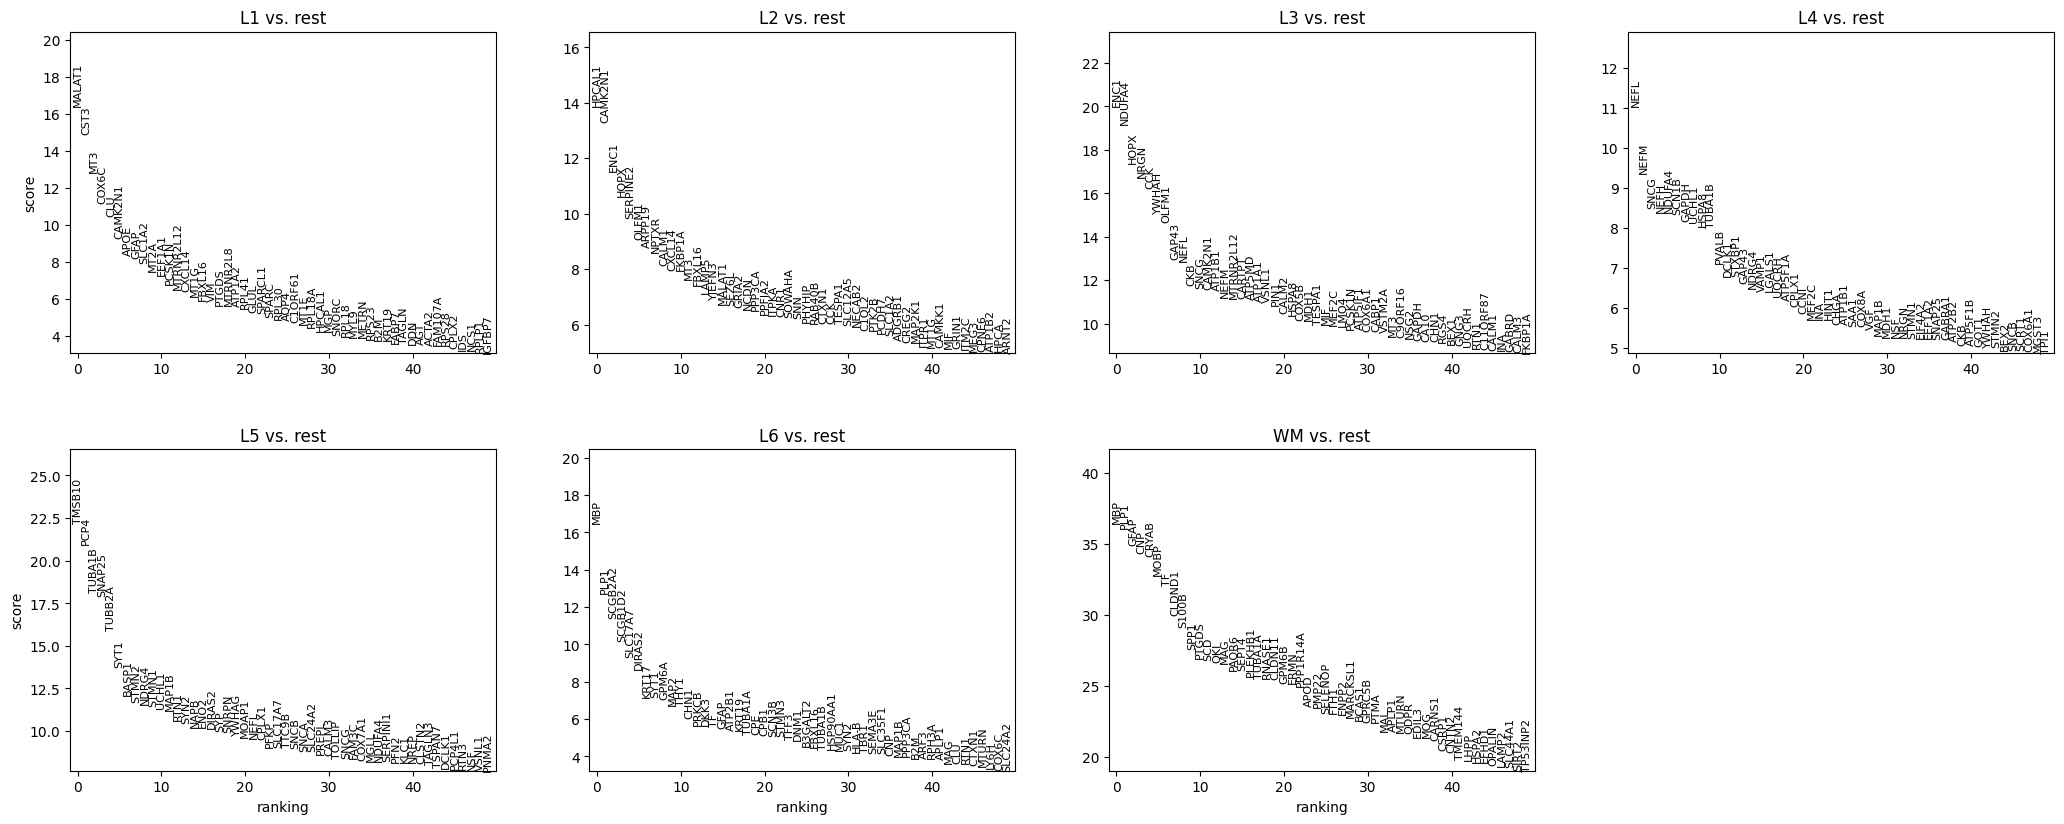

In [11]:
genelistuni = Preprocess_SpTrans(151673)
genelistuni = Preprocess_SpTrans(151674)
genelistuni = Preprocess_SpTrans(151675)
genelistuni = Preprocess_SpTrans(151676)

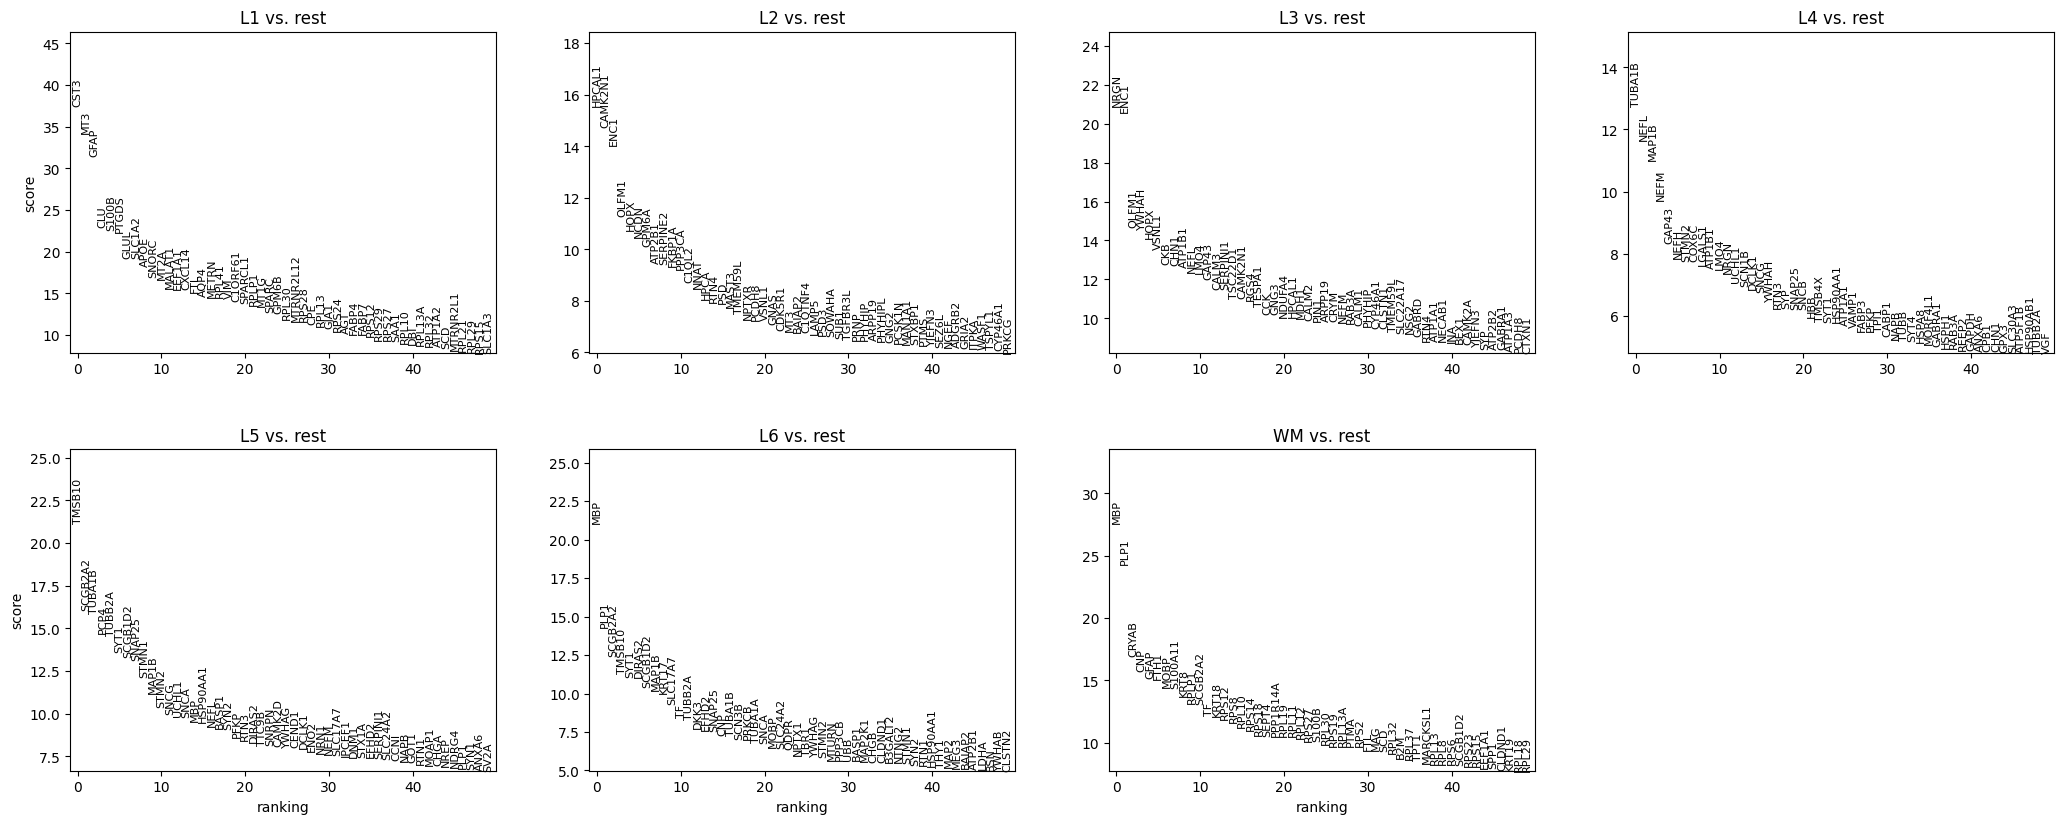

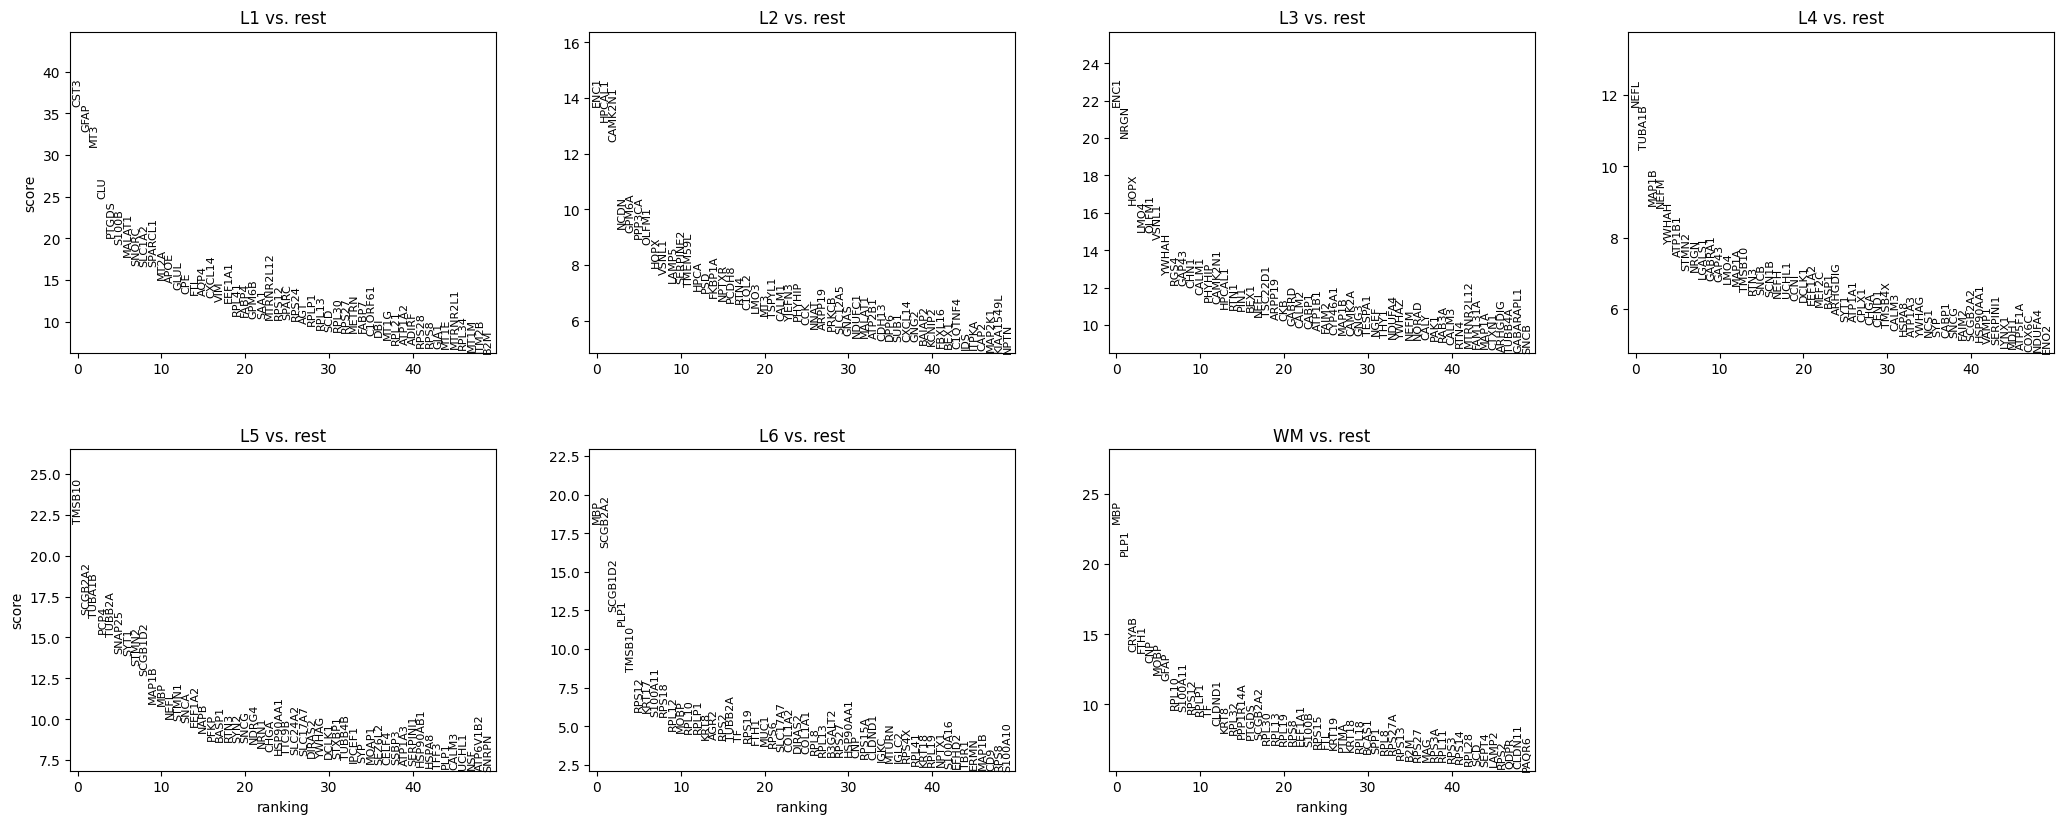

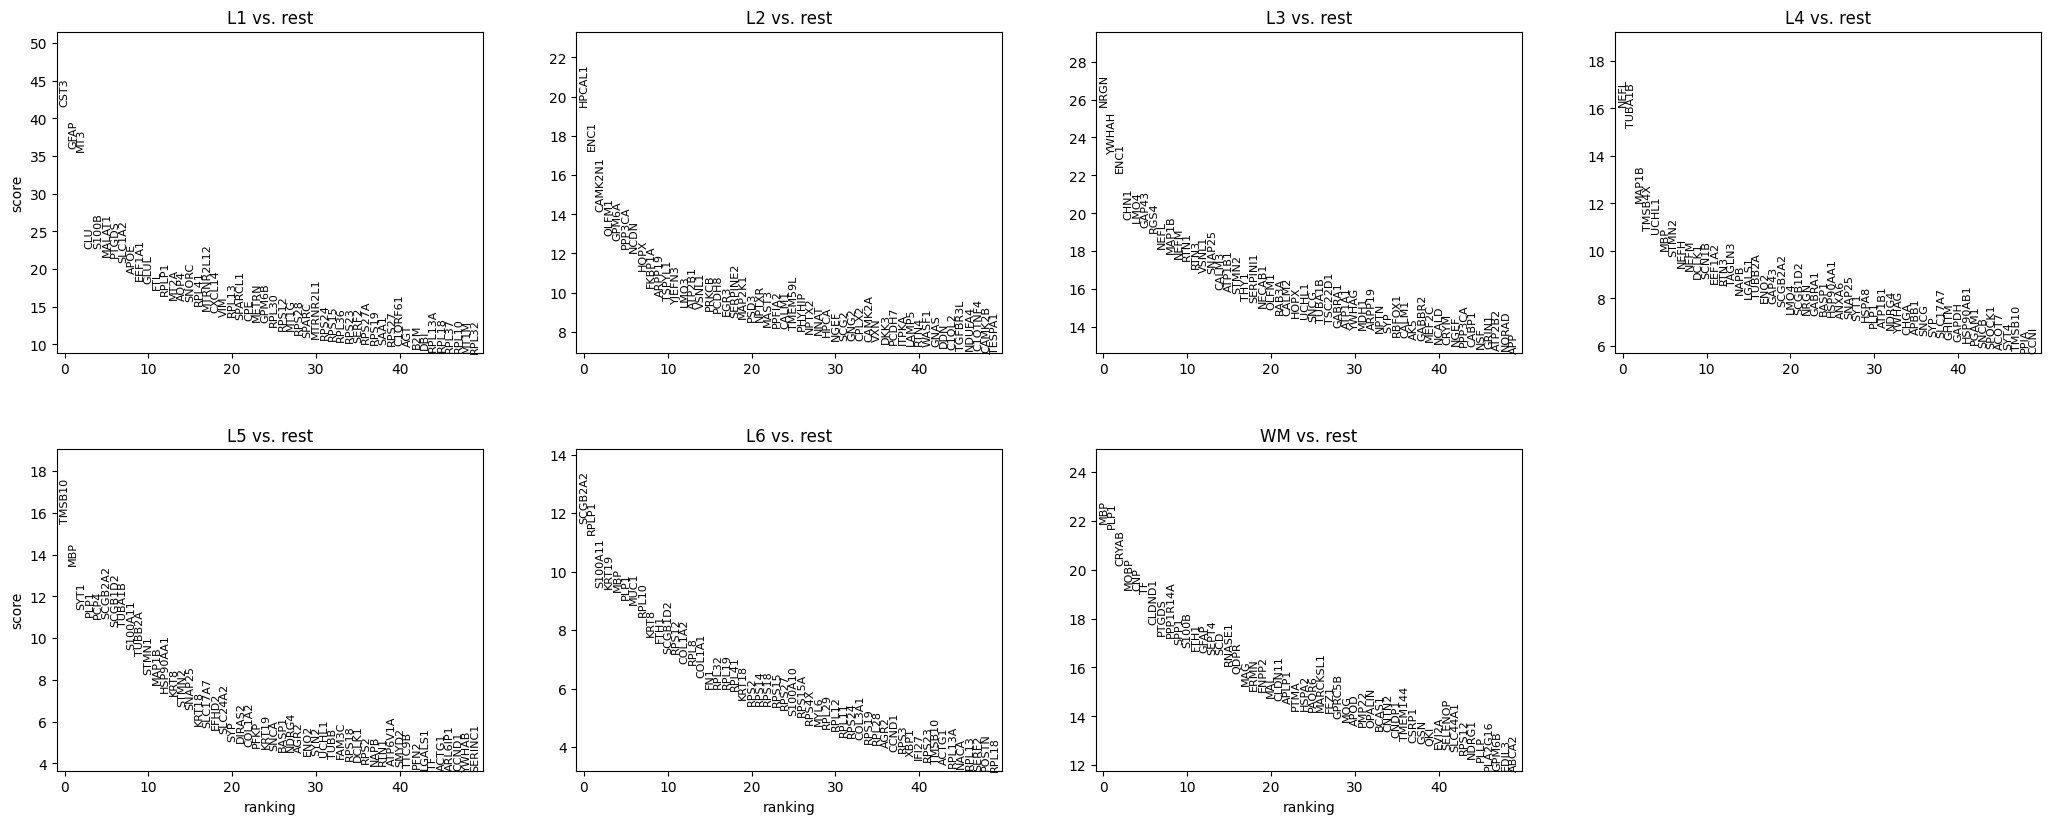

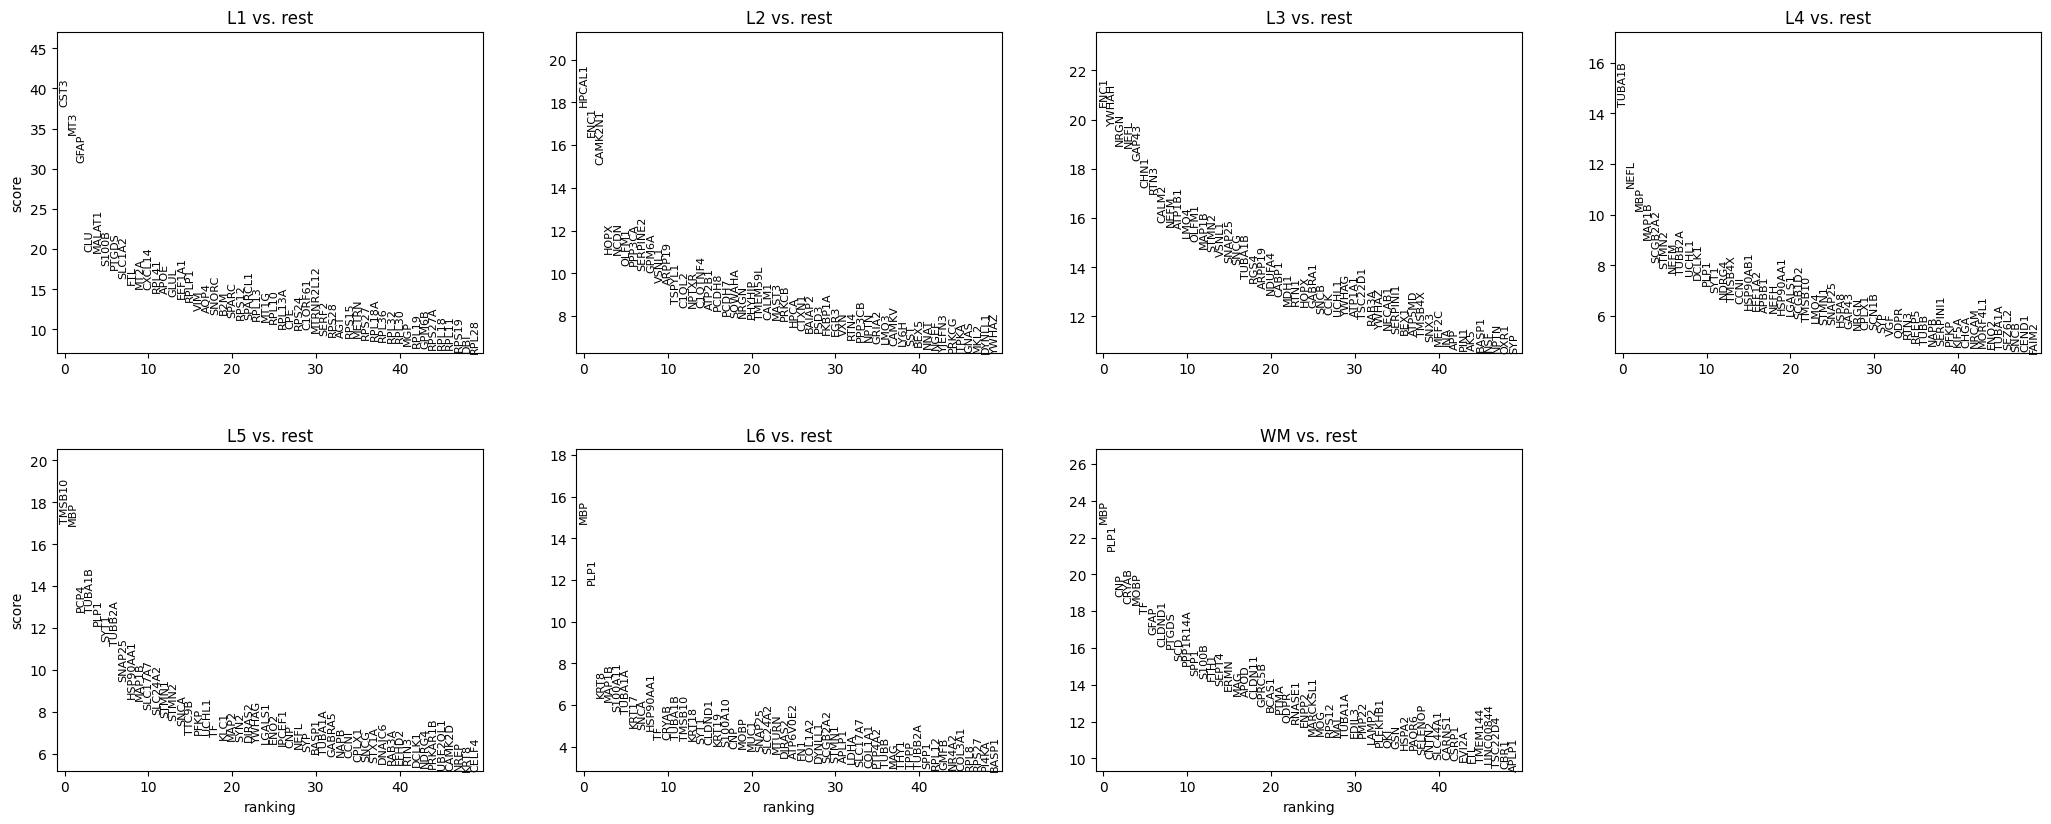

In [12]:
genelistuni = Preprocess_SpTrans(151507)
genelistuni = Preprocess_SpTrans(151508)
genelistuni = Preprocess_SpTrans(151509)
genelistuni = Preprocess_SpTrans(151510)
